In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import pandas as pd

2022-01-09 15:11:38.157232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 15:11:38.157270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
img_rows = 3198
img_cols = 186
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100


In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(3198 * 186 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    
    return model

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

2022-01-09 15:11:40.670705: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-09 15:11:40.670730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kyriakos-GL72M-7RDX): /proc/driver/nvidia/version does not exist
2022-01-09 15:11:40.671673: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def load_dataset():
    file = '/home/kyriakos/Desktop/Projects/Dataset/merged.npy'
    X = np.load(file, allow_pickle=True)
    X = np.reshape(X, (X.shape[0], X.shape[1],X.shape[2]*X.shape[3]))
    X = X/np.max(X)
    return X

In [8]:
X = load_dataset()
file = '/home/kyriakos/Desktop/Projects/Dataset/y.npy'
Y = np.load(file, allow_pickle=True)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [10]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    #(X_train, _), (_, _) = mnist.load_data()
    X = load_dataset()
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)
    x_train = np.expand_dims(x_train, axis=3)
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    #X_train = X_train / 127.5 - 1.0
    #X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in tqdm(range(iterations)):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        #idx = np.random.randint(0, X_train.shape[0], batch_size)
        #imgs = X_train[idx]

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

  5%|▍         | 99/2000 [06:28<2:04:17,  3.92s/it]

100 [D loss: 0.000755, acc.: 100.00%] [G loss: 7.634290]


 10%|▉         | 199/2000 [13:06<1:56:46,  3.89s/it]

200 [D loss: 0.000258, acc.: 100.00%] [G loss: 8.799376]


 15%|█▍        | 299/2000 [19:43<1:59:02,  4.20s/it]

300 [D loss: 0.000029, acc.: 100.00%] [G loss: 9.973345]


 20%|█▉        | 399/2000 [25:56<1:34:32,  3.54s/it]

400 [D loss: 0.000037, acc.: 100.00%] [G loss: 9.809366]


 25%|██▍       | 499/2000 [32:13<1:51:21,  4.45s/it]

500 [D loss: 0.000041, acc.: 100.00%] [G loss: 9.806845]


 30%|██▉       | 599/2000 [39:24<1:49:38,  4.70s/it]

600 [D loss: 0.000311, acc.: 100.00%] [G loss: 9.583961]


 35%|███▍      | 699/2000 [46:08<1:20:46,  3.73s/it]

700 [D loss: 0.050047, acc.: 99.61%] [G loss: 37.638420]


 40%|███▉      | 799/2000 [52:33<1:20:13,  4.01s/it]

800 [D loss: 0.296057, acc.: 99.61%] [G loss: 8.286608]


 45%|████▍     | 899/2000 [59:21<1:16:19,  4.16s/it]

900 [D loss: 0.000000, acc.: 100.00%] [G loss: 13.921179]


 50%|████▉     | 999/2000 [1:05:52<1:04:34,  3.87s/it]

1000 [D loss: 0.010953, acc.: 100.00%] [G loss: 5.972057]


 55%|█████▍    | 1099/2000 [1:12:07<56:47,  3.78s/it]  

1100 [D loss: 0.506084, acc.: 90.62%] [G loss: 77.625832]


 60%|█████▉    | 1199/2000 [1:18:22<50:31,  3.78s/it]  

1200 [D loss: 0.211685, acc.: 96.88%] [G loss: 4.000654]


 65%|██████▍   | 1299/2000 [1:24:51<45:45,  3.92s/it]

1300 [D loss: 9.574044, acc.: 8.59%] [G loss: 27.369595]


 70%|██████▉   | 1399/2000 [1:31:35<43:25,  4.34s/it]

1400 [D loss: 0.293784, acc.: 94.14%] [G loss: 266.948212]


 75%|███████▍  | 1499/2000 [1:38:51<37:58,  4.55s/it]

1500 [D loss: 0.056079, acc.: 100.00%] [G loss: 30.734266]


 80%|███████▉  | 1599/2000 [1:45:50<33:34,  5.02s/it]

1600 [D loss: 0.114867, acc.: 98.44%] [G loss: 28.957136]


 85%|████████▍ | 1699/2000 [1:53:19<20:32,  4.09s/it]

1700 [D loss: 0.213945, acc.: 98.44%] [G loss: 164.449585]


 90%|████████▉ | 1799/2000 [2:00:10<13:58,  4.17s/it]

1800 [D loss: 0.000202, acc.: 100.00%] [G loss: 76.529892]


 95%|█████████▍| 1899/2000 [2:07:13<07:10,  4.26s/it]

1900 [D loss: 1.652698, acc.: 83.98%] [G loss: 10.216558]


100%|█████████▉| 1999/2000 [2:14:09<00:03,  3.96s/it]

2000 [D loss: 0.081374, acc.: 99.22%] [G loss: 142.298737]


100%|██████████| 2000/2000 [2:14:13<00:00,  4.03s/it]


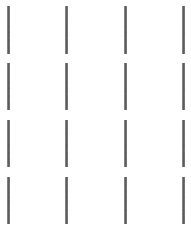

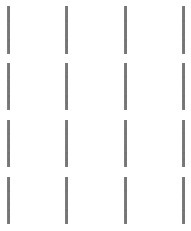

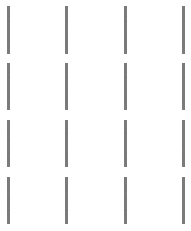

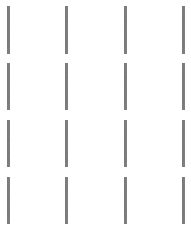

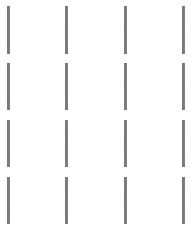

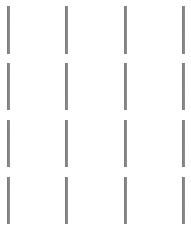

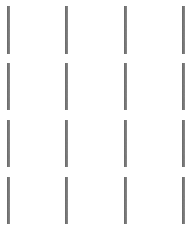

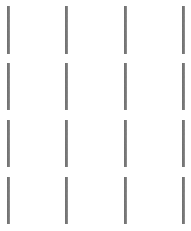

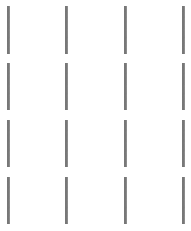

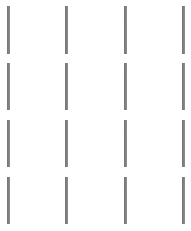

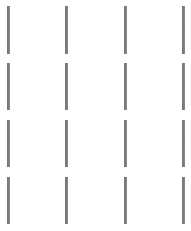

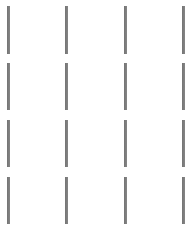

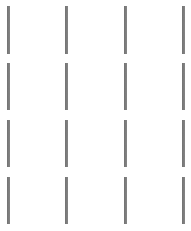

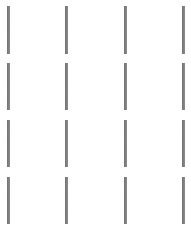

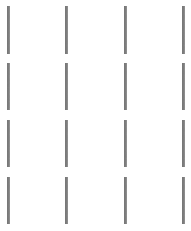

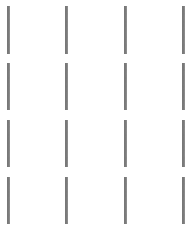

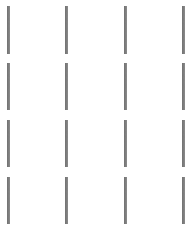

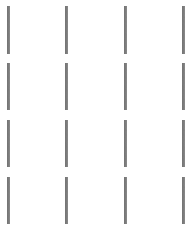

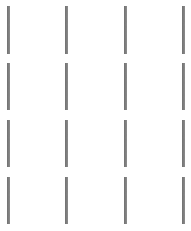

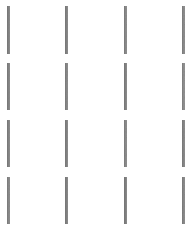

In [12]:
# Set hyperparameters
iterations = 100
batch_size = 128
sample_interval = 10

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [14]:

image_grid_rows=4
image_grid_columns=4
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Generate images from random noise
gen_imgs = generator.predict(z)

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5



In [17]:
gen = gen_imgs[0]
gen = np.reshape(gen, (gen.shape[0], gen.shape[1]*gen.shape[2]))
df = pd.DataFrame(gen)


In [18]:
df.to_csv(r'pandas.txt', header=None, index=None, sep=' ', mode='a')